In [1]:
import scipy.io as scio
import os
import mne
import numpy as np
import time
from IPython import display
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import matplotlib.image as mpimg
import pandas as pd
import seaborn as sns
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test
import scipy.stats as stats
from statannotations.Annotator import Annotator
%matplotlib inline
# sns.set(style="whitegrid")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/tmp/ipykernel_28781/3243943048.py:21: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# STEPS:
# 1. Get Preprocessed Data - Generate Epochs
# 2. Broadband Normalization - Do this in pairs
# 3. Z-Score Comparison - By Patient, comparing days
# 4. Further Stats Analysis

In [ ]:
Statistical Analysis/sEEG_broad_band_z_score.ipynb

PSD Broadband Normalization

In [4]:
# GENERAL SETTINGS:

# 1. Choose Asleep or Awake data
sub_state = 'Asleep'

# 2. Set number of CPU cores to use for computing PSD. Default to -1 unless another user is running an intense program
n_cores = -1 # 1

# 3. Set maximum frequency for MUA 
MUA_max = 500

# 4. Set starting and ending times (in seconds)
tmin, tmax = 0, 300 # Defunct, now variable based on file lengths

# 5. Add in all subject IDs to be analyzed
sub_ids_lst = ['846', '853', '865', '870', '871', '872', '878', '884', '888', '893']

# TEMP:
temp_id = '846'


In [5]:
# data directories
processed_fif_dir = f"../../../George Kenefati/Dan Friedman sEEG Data/Processed FIF Data/"
parent_data_dir = f"../../../George Kenefati/Dan Friedman sEEG Data/Processed FIF Data/"
save_dir = f"../../../George Kenefati/Dan Friedman sEEG Data/PO1 vs last day stats results/"
processed_roi_dir = f"../../../George Kenefati/Dan Friedman sEEG Data/Processed Anatomical Regions Data/"
# Globals
Fs = 2000 # Hz

bmin,bmax = 0,0 # baseline start and end for z-score

# TODO: change to appropriate labels for sEEG data. those below are from source space data
roi_names = [# Right
'rostralanteriorcingulate-rh', # Right Rostral ACC
'caudalanteriorcingulate-rh', # Right Caudal ACC
'postcentral-rh', # , Right S1
'ctx-rh-insula', 'superiorfrontal-rh', # Right Insula, Right DL-PFC
'medialorbitofrontal-rh', # Right Medial-PFC
# Left
 'rostralanteriorcingulate-lh', # Left Rostral ACC
 'caudalanteriorcingulate-lh', # Left Caudal ACC
 'postcentral-lh', # Left S1,
 'ctx-lh-insula', 'superiorfrontal-lh', # Left Insula, Left DL-PFC,
 'medialorbitofrontal-lh' # Left Medial-PFC
]

n_channels = len(roi_names)

In [6]:
def file_pair_generator(file_dir, sub_id, sub_state):
    same_state_double_pairs = []
    day_1_data = []
    day_last_data = []
    for file in os.listdir(file_dir):
        if str(sub_id) in file and str(sub_state) in file and not '512' in file:
            same_state_double_pairs.append(file)
    for i in range(0, len(same_state_double_pairs)):
        if 'Day 1' in same_state_double_pairs[i]:
            day_1_data.append(same_state_double_pairs[i])
        else:
            day_last_data.append(same_state_double_pairs[i])
    return day_1_data, day_last_data

In [7]:
# Automate the generation of broad or MUA (>100 Hz) psds and combine them

def notch_filter_analysis(broad_or_MUA, generated_epochs, psd_broad_lower, picks): # enter 'broad' or 'MUA' for broad_or_MUA argument
    if broad_or_MUA == 'broad':
        broad_band_list = [] # reset
        for i in range(0, (int(MUA_max/60)-1)):
            if i == 0:
                broad_band = generated_epochs.compute_psd(fmin=65., fmax=117., picks=picks, n_jobs=n_cores)
                broad_band_list.append(broad_band)
            elif i == (int(MUA_max/60)-1):
                broad_band = generated_epochs.compute_psd(fmin=63+i*60., fmax = MUA_max, picks = picks, n_jobs=n_cores)
                broad_band_list.append(broad_band)
            else:
                broad_band = generated_epochs.compute_psd(fmin=63+i*60., fmax=57+(i+1)*60., picks=picks, n_jobs=n_cores)
                broad_band_list.append(broad_band)
        broad_band_list.append(psd_broad_lower)
        broad_psd_arr = np.concatenate(broad_band_list, axis=2)
        return(broad_psd_arr)
    elif broad_or_MUA == 'MUA':
        MUA_band_list = [] # reset
        for i in range(0, (int(MUA_max/60)-1)):
            if i == 0:
                MUA_band = generated_epochs.compute_psd(fmin=100., fmax = 117., picks=picks, n_jobs=n_cores)
                MUA_band_list.append(MUA_band)
            elif i == int(MUA_max/60-1):
                MUA_band = generated_epochs.compute_psd(fmin=63+i*60, fmax = MUA_max, picks=picks, n_jobs=n_cores)
                MUA_band_list.append(MUA_band)
            else:
                MUA_band = generated_epochs.compute_psd(fmin = 63+i*60., fmax = 117+i*60., picks=picks, n_jobs=n_cores)
                MUA_band_list.append(MUA_band)
        MUA_psd_arr = np.concatenate(MUA_band_list, axis=2)
        return(MUA_psd_arr)

In [8]:
# Insert the file path and the file pairs, along with the selected picks for that paticular subject
# Will return list of arrays for each of the different sub bands
# 0-Delta, 1-Theta, 2-Alpha, 3-Beta, 4-Low Gamma, 5-High Gamma, 6-MUA

def avg_psd_arr_generator(fif_file_path, file_pair, picks):
    
    delta_norm = []
    theta_norm = []
    alpha_norm = []
    beta_norm = []
    low_gamma_norm = []
    high_gamma_norm = []
    MUA_norm = []
    
    psd_arr_lst = [] # reset
    for i in range(0, len(file_pair)):
        raw = mne.io.read_raw_fif(os.path.join(fif_file_path, str(file_pair[i]))).load_data()
        print(f"processing data for {file_pair[i]}")
        raw = raw.notch_filter(np.arange(120, 481, 60), n_jobs=-1, fir_design='firwin', notch_widths = 6) # inital notch filter for all harmonics
        epochs = mne.make_fixed_length_epochs(raw, duration=30, preload=False)
        n_fft = 2048  # the FFT size (n_fft). Ideally a power of 2

    # Calculate the psds from raw data based on frequency range
        broad1 = epochs.compute_psd(fmin=1., fmax=55., picks=picks, n_jobs=n_cores)
        delta = epochs.compute_psd(fmin=1., fmax=4., picks=picks, n_jobs=n_cores)
        theta = epochs.compute_psd(fmin=4., fmax=8., picks=picks, n_jobs=n_cores)
        alpha = epochs.compute_psd(fmin=8., fmax=13., picks=picks, n_jobs=n_cores)
        beta = epochs.compute_psd(fmin=13., fmax=30., picks=picks, n_jobs=n_cores)
        low_gamma = epochs.compute_psd(fmin=30., fmax=55., picks=picks, n_jobs=n_cores)
        high_gamma = epochs.compute_psd(fmin=65., fmax=100., picks=picks, n_jobs=n_cores)
 
        
    # Calculate the average MUA and larger broad frequencies using the notch filter analysis function

        broad_psd_arr = notch_filter_analysis('broad', epochs, broad1, picks)
        MUA = notch_filter_analysis('MUA', epochs, broad1, picks) # Final argument is neccecary for funtion, but plays no part in MUA calculations
        print(f"applying notch filter across all epochs for broad2 analysis and MUA frequencies")


    # Combine broad spectrum powers and take the trace
        trace_psd_broad = np.trace(broad_psd_arr, axis1 = 1, axis2 = 2)
        display.clear_output()
        
        psd_delta = []
        psd_theta = []
        psd_alpha = []
        psd_beta = []
        psd_low_gamma = []
        psd_high_gamma = []
        psd_MUA = []
        
        for j in range(0, len(trace_psd_broad)):
            psd_delta.append(10 * np.log10(delta.get_data()[j] / trace_psd_broad[j]))
            psd_theta.append(10 * np.log10(theta.get_data()[j] / trace_psd_broad[j]))
            psd_alpha.append(10 * np.log10(alpha.get_data()[j] / trace_psd_broad[j]))
            psd_beta.append(10 * np.log10(beta.get_data()[j] / trace_psd_broad[j]))
            psd_low_gamma.append(10 * np.log10(low_gamma.get_data()[j] / trace_psd_broad[j]))
            psd_high_gamma.append(10 * np.log10(high_gamma.get_data()[j] / trace_psd_broad[j]))
            psd_MUA.append(10 * np.log10(MUA[j] / trace_psd_broad[j]))
            
        norm_psd_delta = np.array(psd_delta)
        norm_psd_theta = np.array(psd_theta)
        norm_psd_alpha = np.array(psd_alpha)
        norm_psd_beta = np.array(psd_beta)
        norm_psd_low_gamma = np.array(psd_low_gamma)
        norm_psd_high_gamma = np.array(psd_high_gamma)
        norm_psd_MUA = np.array(psd_MUA)
        
        delta_norm.append(norm_psd_delta)
        theta_norm.append(norm_psd_theta)
        alpha_norm.append(psd_alpha)
        beta_norm.append(psd_beta)
        low_gamma_norm.append(psd_low_gamma)
        high_gamma_norm.append(psd_high_gamma)
        MUA_norm.append(psd_MUA)
    
    combined_psd_norm = [delta_norm, theta_norm, alpha_norm, beta_norm, low_gamma_norm, high_gamma_norm, MUA_norm]
    for z in range(len(combined_psd_norm)):
        combined_psd_norm[z] = np.concatenate([combined_psd_norm[z][0], combined_psd_norm[z][1]], axis = 2)
    return combined_psd_norm

In [35]:
psd_norm_test = avg_psd_arr_generator(processed_fif_dir, first_day, selected_picks)

In [16]:
print(psd_norm_test[5].shape)

(10, 13, 2102)


In [32]:
print(psd_norm_test[0][9, 1].shape)

(182,)


In [33]:
# baseline_epoch ==> range(0 - 9) represents the 30 second period we want to use for the baseline mean and std

def z_score_calculator(psd_arr, baseline_epoch):
    for i in range(len(psd_arr)):
        print(f'analyzing for broad band: {i}')
        for j in range((psd_arr[0].shape[0] - 1)):
            if j == baseline_epoch:
                print(f'skipping baseline epoch: {j}')
                continue
            else:
                for z in range(psd_arr[0].shape[1]):
                    print(f'performing z score analysis on broad band: {i}, on epoch: {j}, and channel: {z}')
                    baseline_mean = np.mean(psd_arr[i][baseline_epoch, z])
                    baseline_std = np.std(psd_arr[i][baseline_epoch, z])
                    print(f'baseline mean for epoch: {j} and channel: {z} is: {baseline_mean}, std is: {baseline_std}')
                    psd_arr[i][j, z] = (psd_arr[i][j, z] - baseline_mean) / baseline_std
                    print(f'process complete, moving onto next channel')
    return psd_arr
                

In [38]:
post_z_score_test = z_score_calculator(psd_norm_test, 9)

analyzing for broad band: 0
performing z score analysis on broad band: 0, on epoch: 0, and channel: 0
baseline mean for epoch: 0 and channel: 0 is: 30.689227042204866, std is: 6.3842486429396335
process complete, moving onto next channel
performing z score analysis on broad band: 0, on epoch: 0, and channel: 1
baseline mean for epoch: 0 and channel: 1 is: 31.648726862113406, std is: 5.785008818036336
process complete, moving onto next channel
performing z score analysis on broad band: 0, on epoch: 0, and channel: 2
baseline mean for epoch: 0 and channel: 2 is: 32.58060256223666, std is: 5.239715259215906
process complete, moving onto next channel
performing z score analysis on broad band: 0, on epoch: 0, and channel: 3
baseline mean for epoch: 0 and channel: 3 is: 30.9135492104884, std is: 6.143840367644164
process complete, moving onto next channel
performing z score analysis on broad band: 0, on epoch: 0, and channel: 4
baseline mean for epoch: 0 and channel: 4 is: 32.56773628391419,

In [39]:
psd_norm_test[0][2, 1]

array([ 3.78805605e-01,  3.60587356e-01,  8.20053191e-01,  7.39791416e-01,
        8.17209981e-01,  8.53511984e-01,  9.06165906e-01,  9.39372993e-01,
        9.46732203e-01,  6.80361435e-01,  9.15732868e-01,  8.55940097e-01,
        8.40363369e-01,  8.81611364e-01,  1.05725522e+00,  1.06473305e+00,
        9.63599978e-01,  1.05710332e+00,  9.84892751e-01,  1.03444116e+00,
        1.03432038e+00,  9.70483687e-01,  7.58348817e-01,  7.40328347e-01,
        6.05387674e-01,  5.55784553e-01,  4.57335596e-01,  4.77062350e-01,
        4.21098038e-01,  6.88810303e-01,  6.60247655e-01,  7.48635372e-01,
        6.37490992e-01,  5.41722503e-01,  2.55894681e-01,  3.18097190e-01,
        4.66927700e-04, -7.16208816e-03, -2.12656363e-01, -3.94354539e-01,
       -2.26291020e-01, -4.70982776e-01, -5.99690190e-01, -6.23586900e-01,
       -5.38508394e-01, -4.38233209e-01, -3.77267297e-01, -5.57484310e-01,
       -5.88940856e-01, -5.12599042e-01, -6.00300296e-01, -4.55427083e-01,
       -4.17013359e-01, -

In [37]:
post_z_score_test[0][2, 1]

array([-5.40533684, -5.40848605, -5.32906252, -5.34293662, -5.329554  ,
       -5.32327881, -5.31417703, -5.30843683, -5.30716471, -5.35320972,
       -5.31252328, -5.32285909, -5.32555169, -5.31842154, -5.28805964,
       -5.28676702, -5.30424894, -5.2880859 , -5.30056826, -5.29200329,
       -5.29202417, -5.30305902, -5.33972877, -5.3428438 , -5.36616973,
       -5.37474415, -5.3917621 , -5.38835212, -5.39802614, -5.35174924,
       -5.3566866 , -5.34140785, -5.36062033, -5.37717493, -5.42658329,
       -5.41583093, -5.47073668, -5.47205544, -5.5075773 , -5.53898575,
       -5.50993419, -5.55223175, -5.57448019, -5.57861099, -5.56390427,
       -5.54657064, -5.53603204, -5.56718446, -5.57262205, -5.55942556,
       -5.57458565, -5.54954278, -5.54290257, -5.5492605 , -5.55735939,
       -5.55101898, -5.56168924, -5.55613172, -5.55101016, -5.52376395,
       -5.53197498, -5.48263809, -5.46597986, -5.4766051 , -5.49307328,
       -5.5147535 , -5.49691413, -5.48509966, -5.53235763, -5.53

In [9]:
def ROI_Depth_Generator(ROI_Data_Path, ROI_sub_id): # use for files containing 'depth'
    for file in os.listdir(ROI_Data_Path):
        if str(ROI_sub_id) in file and str('depth') in file:
            processed_roi_csv = pd.read_csv(os.path.join(ROI_Data_Path, file))
    
    ROI_channels = processed_roi_csv['ID'].to_list()
    return(ROI_channels)

In [10]:
selected_picks = ROI_Depth_Generator(processed_roi_dir, temp_id)
selected_picks

['DLI05',
 'DLI06',
 'DLI07',
 'DLI08',
 'DLI09',
 'DRI01',
 'DRI02',
 'DRI03',
 'DRI04',
 'DRI05',
 'DRI06',
 'DRI07',
 'DRI08']

In [11]:
for j in range(0, len(selected_picks)):
    if selected_picks[j][-2:][:-1] == '0':
        selected_picks[j] = selected_picks[j][:-2] + selected_picks[j][-1:]
selected_picks

['DLI5',
 'DLI6',
 'DLI7',
 'DLI8',
 'DLI9',
 'DRI1',
 'DRI2',
 'DRI3',
 'DRI4',
 'DRI5',
 'DRI6',
 'DRI7',
 'DRI8']

In [12]:
# Testing:

# file_pair_generator - Functional
first_day, last_day = file_pair_generator(processed_fif_dir, temp_id, sub_state)

# first_day_psd_arr = avg_psd_arr_generator(processed_fif_dir, first_day, selected_picks)
# last_day_psd_arr = avg_psd_arr_generator(processed_fif_dir, last_day, selected_picks)


In [115]:
print(first_day_psd_arr.shape)
print(last_day_psd_arr.shape)

(14, 10, 13)
(14, 10, 13)


In [87]:
raw_first = mne.io.read_raw_edf('../../../George Kenefati/Dan Friedman sEEG Data/NY846/Day 1/Asleep1/Asleep1.EDF')
raw_last = mne.io.read_raw_edf('../../../George Kenefati/Dan Friedman sEEG Data/NY846/Day 8/Asleep1/Asleep1.EDF')

Extracting EDF parameters from /media/sb10flpc002/08e63286-43ce-4f61-9491-1ed048c96f20/George Kenefati/Dan Friedman sEEG Data/NY846/Day 1/Asleep1/Asleep1.EDF...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /media/sb10flpc002/08e63286-43ce-4f61-9491-1ed048c96f20/George Kenefati/Dan Friedman sEEG Data/NY846/Day 8/Asleep1/Asleep1.EDF...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  24 | elapsed:    0.7s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  11 out of  24 | elapsed:    1.0s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  16 out of  24 | elapsed:    1.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  21 out of  24 | elapsed:    1.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    2.0s finished


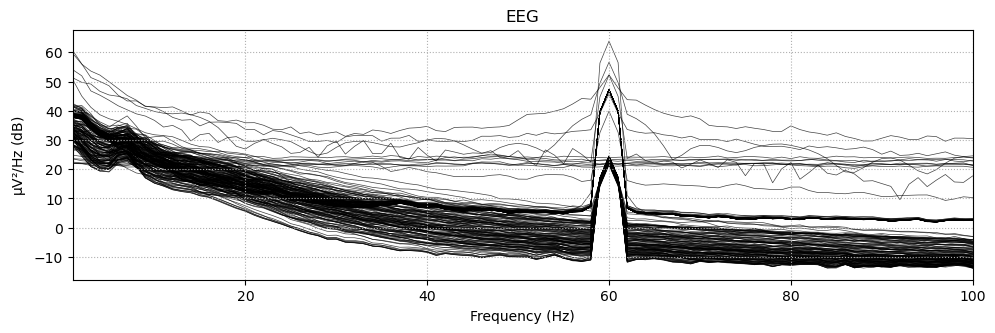

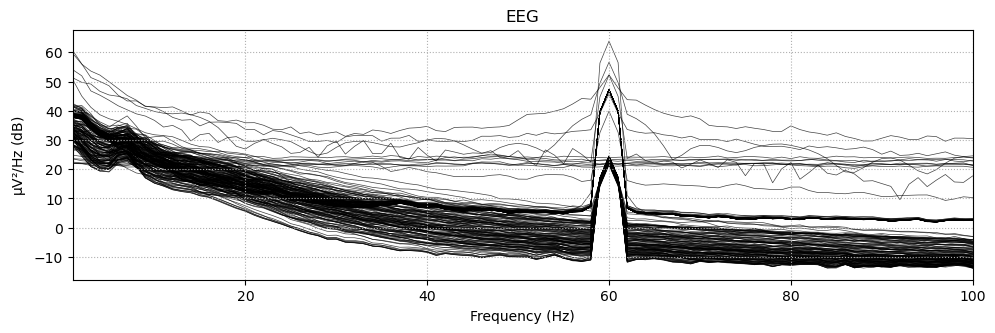

In [92]:
raw_first.compute_psd(fmin = 1, fmax = 100, n_jobs = -1).plot()

Effective window size : 1.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  24 | elapsed:    0.6s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  11 out of  24 | elapsed:    1.0s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  16 out of  24 | elapsed:    1.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  21 out of  24 | elapsed:    1.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    2.0s finished


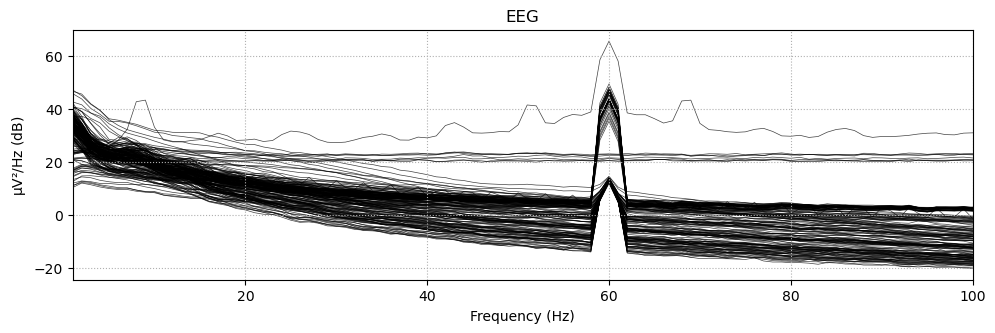

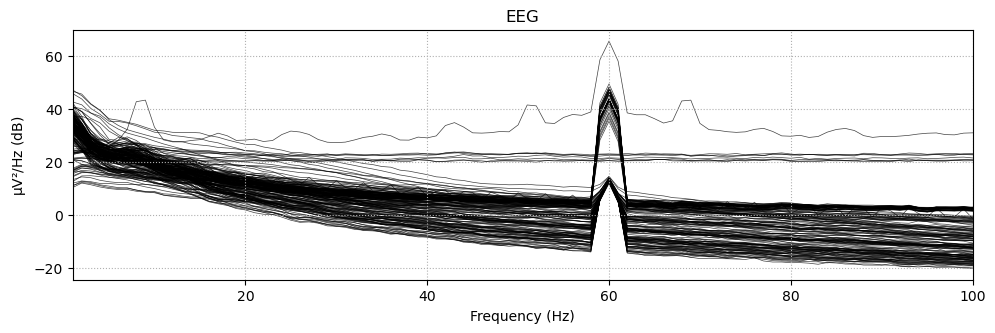

In [93]:
raw_last.compute_psd(fmin = 1, fmax = 100, n_jobs = -1).plot()

In [127]:
max_times = []
for file in os.listdir(processed_info_dir):
    if temp_id in file and not '512' in file and str(sub_state) in file:
        raw_file = mne.io.read_raw_fif(os.path.join(processed_info_dir, str(file)))
        raw_df = raw_file.to_data_frame()
        max_times.append(raw_df['time'][-1:].item())
tmax = (min(max_times))
tmin = (min(max_times)-30)

Opening raw data file ../../../George Kenefati/Dan Friedman sEEG Data/Processed FIF Data/NY846_Day 1_Asleep2-raw.fif...
Isotrak not found
    Range : 0 ... 615039 =      0.000 ...   300.312 secs
Ready.
Opening raw data file ../../../George Kenefati/Dan Friedman sEEG Data/Processed FIF Data/NY846_Day 8_Asleep1-raw.fif...
Isotrak not found
    Range : 0 ... 616063 =      0.000 ...   300.812 secs
Ready.
Opening raw data file ../../../George Kenefati/Dan Friedman sEEG Data/Processed FIF Data/NY846_Day 1_Asleep1-raw.fif...
Isotrak not found
    Range : 0 ... 617087 =      0.000 ...   301.312 secs
Ready.
Opening raw data file ../../../George Kenefati/Dan Friedman sEEG Data/Processed FIF Data/NY846_Day 8_Asleep2-raw.fif...
Isotrak not found
    Range : 0 ... 617087 =      0.000 ...   301.312 secs
Ready.


In [130]:
print(tmax)
print(tmin)

300.31201171875
270.31201171875


In [122]:
# Z-SCORE CALCULATION SETTINGS

# 1. Choose Asleep1, Asleep2, Awake1, or Awake2 - Arbitrary from current understanding, doesn't really matter for calculations
zsub_state = 'Asleep1'

# 2. Choose time frame of baseline z-score - VALUES MUST BE FLOAT (decimal at the end)
# IMPORTANT: note that all future time frames must match the baseline in length
# NOTE: we discovered that the recordings deviate somewhat from exactly 300 seconds, so below is a script to find the tmax so all our recordings are the same
# we will take the length of the shortest recording as a our tmax and we can choose the length of the baseline

baseline_duration = 30 # Length of the window used to calculate the baseline mean and std

# Script below will create a dictionary of tmaxes based off the sub_ids_lst which lists all our subids

In [131]:
def z_score_calculator(data_dir, zsub_state, sub_id, picks, ztmin, ztmax):
    file_list = [] # reset
    for file in os.listdir(data_dir):
        if sub_id in file and not '512' in file and str(zsub_state)[:-1] in file:
            file_list.append(file)
            print(f"file added to analyzing list: {file}")
            
    z_score_arr_lst = [] # reset
    
    for l in range(len(file_list)):
        if str(zsub_state) in file_list[l] and not 'Day 1' in file_list[l]:
            raw = mne.io.read_raw_fif(os.path.join(data_dir, file_list[l])).crop(ztmin, ztmax)
            raw_df = raw.to_data_frame(picks = picks)
            selected_df = raw_df[raw_df['time'] > ztmin]
            selected_df = selected_df[selected_df['time'] < ztmax] 
            base_mean = np.mean(selected_df)
            base_std = np.std(selected_df)
            display.clear_output()
            print(f"The baseline mean is: {base_mean} | The baseline std is: {base_std}")
        
    for k in range(len(file_list)):
        z_score_list = []
        if zsub_state in str(file_list[k]) and not 'Day 1' in str(file_list[k]):
            if ztmin > 0 and ztmax < 300:
                raw_df = raw_df[raw_df['time'] < ztmin]
                raw_df = raw_df[raw_df['time'] > ztmax]
            elif ztmax == 300:
                raw_df = raw_df[raw_df['time'] < (ztmax - (ztmax-ztmin))]
            else:
                raw_df = raw_df[raw_df['time'] > (ztmin + (ztmax-ztmin))]
            
            print(f"Shape of raw data in file: {file_list[k]}: {raw_df.shape}")

            for i in range(1, (raw_df.shape[1])):
                column = raw_df.iloc[:,i].to_list()
                z_scores = [] # reset
                for j in range(0, len(column)):
                    z_score = (column[j] - base_mean[i]) / base_std[i]
                    z_scores.append(z_score)
                z_score_list.append(z_scores)
            final_day_z_score_arr = np.array(z_score_list)        
            print(f"Process #{k}, for file: {file_list[k]}, shape is {z_score_arr.shape}")

        else:
            raw = mne.io.read_raw_fif(os.path.join(data_dir, str(file_list[k]))).crop(ztmin, ztmax)
            raw_df = raw.to_data_frame(picks = picks)
            print(f"Shape of raw data in file: {file_list[k]}: {raw_df.shape}")
            for i in range(1, (raw_df.shape[1])):
                column = raw_df.iloc[:,i].to_list()
                z_scores = [] # reset
                for j in range(0, len(column)):
                    z_score = (column[j] - base_mean[i]) / base_std[i] 
                    z_scores.append(z_score)
                z_score_list.append(z_scores)
            z_score_arr = np.array(z_score_list)
            z_score_arr_lst.append(z_score_arr)
            print(f"Process #{k}, for file: {file_list[k]}, shape is {z_score_arr.shape}")
            
    z_score_full_arr = np.stack(z_score_arr_lst, axis=-1) # stacks the individual z score arrays, with 3rd dimension representing each array
    return(z_score_full_arr, final_day_z_score_arr) # returns two separate arrays because array for calculating bas
    
            
        
    


In [132]:
z_score_calculator(processed_fif_dir, zsub_state, temp_id, selected_picks, tmin, tmax)

The baseline mean is: time   NaN
DLI5   NaN
DLI6   NaN
DLI7   NaN
DLI8   NaN
DLI9   NaN
DRI1   NaN
DRI2   NaN
DRI3   NaN
DRI4   NaN
DRI5   NaN
DRI6   NaN
DRI7   NaN
DRI8   NaN
dtype: float64 | The baseline std is: time   NaN
DLI5   NaN
DLI6   NaN
DLI7   NaN
DLI8   NaN
DLI9   NaN
DRI1   NaN
DRI2   NaN
DRI3   NaN
DRI4   NaN
DRI5   NaN
DRI6   NaN
DRI7   NaN
DRI8   NaN
dtype: float64
Opening raw data file ../../../George Kenefati/Dan Friedman sEEG Data/Processed FIF Data/NY846_Day 1_Asleep2-raw.fif...
Isotrak not found
    Range : 0 ... 615039 =      0.000 ...   300.312 secs
Ready.
Shape of raw data in file: NY846_Day 1_Asleep2-raw.fif: (61441, 14)
Process #0, for file: NY846_Day 1_Asleep2-raw.fif, shape is (13, 61441)
Shape of raw data in file: NY846_Day 8_Asleep1-raw.fif: (0, 14)
Process #1, for file: NY846_Day 8_Asleep1-raw.fif, shape is (13, 61441)
Opening raw data file ../../../George Kenefati/Dan Friedman sEEG Data/Processed FIF Data/NY846_Day 1_Asleep1-raw.fif...
Isotrak not found
 

(array([[[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],
 
        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],
 
        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],
 
        ...,
 
        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],
 
        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],
 
        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
  